#### PPO

In [1]:
import shutup
shutup.please()

In [2]:
import numpy as np

from src.agents.agent import Agent
from src.utils.buffer import Buffer
from src.utils.logger import LearningLogger

import scipy.signal
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_probability as tfp

from tensorflow.keras.layers import Input, Dense, Concatenate



In [3]:
import tensorflow as tf
import os
import numpy as np
import random

SEED = 0

def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

def set_global_determinism(seed=SEED):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

# Call the above function with seed value
#set_global_determinism(seed=SEED)

episode: 1/10000, score: -449.0862955802017, average: -449.09 
episode: 2/10000, score: -37.60886121498163, average: -243.35 
episode: 3/10000, score: -100.2897984424541, average: -195.66 
episode: 4/10000, score: -150.29810991546555, average: -184.32 
episode: 5/10000, score: -460.13772773389115, average: -239.48 
episode: 6/10000, score: -250.97623847844474, average: -241.40 
episode: 7/10000, score: -382.48333979935694, average: -261.55 
episode: 8/10000, score: -191.18842633387737, average: -252.76 
episode: 9/10000, score: -256.1982384202954, average: -253.14 
episode: 10/10000, score: -94.03743520026194, average: -237.23 
episode: 11/10000, score: -135.69441350074925, average: -228.00 
episode: 12/10000, score: -109.4914912308267, average: -218.12 
episode: 13/10000, score: -94.69903178549256, average: -208.63 
episode: 14/10000, score: -98.0619604605894, average: -200.73 
episode: 15/10000, score: -325.75625650977906, average: -209.07 
episode: 16/10000, score: -109.673053851066

episode: 129/10000, score: -296.22112812256466, average: -64.65 
episode: 130/10000, score: 29.447738036536435, average: -59.33 
episode: 131/10000, score: -85.382043308035, average: -58.86 
episode: 132/10000, score: -101.97564204844798, average: -57.96 
episode: 133/10000, score: -6.932922651820704, average: -56.01 
episode: 134/10000, score: -27.62582919178938, average: -55.96 
episode: 135/10000, score: -103.99529985335951, average: -56.74 
episode: 136/10000, score: -203.72042597972018, average: -60.17 
episode: 137/10000, score: -454.9164258344679, average: -68.42 
episode: 138/10000, score: -76.07292284497827, average: -68.62 
episode: 139/10000, score: -45.62598335133728, average: -68.63 
episode: 140/10000, score: -38.30381991862603, average: -64.16 
episode: 141/10000, score: -43.07090791948222, average: -63.26 
episode: 142/10000, score: -56.68601133667859, average: -63.26 
episode: 143/10000, score: -94.38924317091569, average: -63.38 
episode: 144/10000, score: -143.153190

episode: 255/10000, score: -240.01822354411422, average: -138.11 
episode: 256/10000, score: -210.95518189395722, average: -141.11 
episode: 257/10000, score: -170.72409718230068, average: -140.36 
episode: 258/10000, score: -222.23417831115276, average: -143.80 
episode: 259/10000, score: -182.40674551177364, average: -141.99 
episode: 260/10000, score: -182.48878418472304, average: -142.50 
episode: 261/10000, score: -137.03922357683197, average: -143.04 
episode: 262/10000, score: -222.67259807508083, average: -143.30 
episode: 263/10000, score: -102.12485258521558, average: -143.26 
episode: 264/10000, score: -164.8168431416692, average: -144.44 
episode: 265/10000, score: -101.11419867570304, average: -144.25 
episode: 266/10000, score: -125.02446432667381, average: -144.80 
episode: 267/10000, score: -95.91180830805521, average: -141.22 
episode: 268/10000, score: -138.21454157095832, average: -142.12 
episode: 269/10000, score: -71.39042803628816, average: -141.95 
episode: 270/

episode: 381/10000, score: -61.76436685094255, average: -115.08 
episode: 382/10000, score: -157.28034518401805, average: -117.21 
episode: 383/10000, score: -88.99738320192262, average: -118.49 
episode: 384/10000, score: -151.20795187438137, average: -119.61 
episode: 385/10000, score: -167.73794468984102, average: -120.02 
episode: 386/10000, score: -75.48308074183817, average: -120.10 
episode: 387/10000, score: -138.55416068264705, average: -120.71 
episode: 388/10000, score: -116.52801675862521, average: -121.87 
episode: 389/10000, score: -160.72698977255578, average: -123.39 
episode: 390/10000, score: -195.36356726386526, average: -122.81 
episode: 391/10000, score: -78.93639918450674, average: -122.46 
episode: 392/10000, score: -49.28675817606348, average: -120.60 
episode: 393/10000, score: -152.94336323704428, average: -121.68 
episode: 394/10000, score: -59.71428301902306, average: -119.52 
episode: 395/10000, score: -61.47732954933856, average: -117.30 
episode: 396/1000

episode: 509/10000, score: 71.2435956226366, average: 14.45 
episode: 510/10000, score: 72.05526859110486, average: 18.52 
episode: 511/10000, score: 111.53820396767046, average: 19.01 SAVING
episode: 512/10000, score: 113.36936546077992, average: 20.05 SAVING
episode: 513/10000, score: -13.326533222021936, average: 23.46 SAVING
episode: 514/10000, score: -31.60808842820454, average: 20.62 
episode: 515/10000, score: -98.7280202268162, average: 21.03 
episode: 516/10000, score: -101.81814334697113, average: 20.22 
episode: 517/10000, score: 69.14950780478901, average: 23.61 SAVING
episode: 518/10000, score: -114.48994841940858, average: 22.83 
episode: 519/10000, score: -2.575291672610618, average: 24.06 SAVING
episode: 520/10000, score: -105.49857112431401, average: 17.95 
episode: 521/10000, score: 64.88107768599667, average: 17.58 
episode: 522/10000, score: 85.52257446662205, average: 21.05 
episode: 523/10000, score: 147.4852782940275, average: 22.35 
episode: 524/10000, score: -8

episode: 640/10000, score: -25.54384502352017, average: -6.05 
episode: 641/10000, score: 174.6363734447921, average: -2.68 
episode: 642/10000, score: 112.2699702897113, average: -0.68 
episode: 643/10000, score: 164.8023214806762, average: 3.04 
episode: 644/10000, score: 127.69385711653396, average: 4.49 
episode: 645/10000, score: -170.7697654228819, average: 0.17 
episode: 646/10000, score: -155.20865625972027, average: -1.21 
episode: 647/10000, score: -42.05553193359311, average: -4.77 
episode: 648/10000, score: 85.43826084738026, average: -2.50 
episode: 649/10000, score: 69.36092600542038, average: -2.51 
episode: 650/10000, score: 75.57084254834338, average: 0.62 
episode: 651/10000, score: 79.14267601444062, average: 4.58 
episode: 652/10000, score: 45.54794488914462, average: 6.50 
episode: 653/10000, score: -109.72190893105184, average: 6.90 
episode: 654/10000, score: 175.34723993103768, average: 10.59 
episode: 655/10000, score: 78.01304823678015, average: 11.22 
episod

episode: 769/10000, score: 158.19533006613239, average: 70.22 
episode: 770/10000, score: -66.10142836911038, average: 65.52 
episode: 771/10000, score: 165.95296364609638, average: 70.36 
episode: 772/10000, score: 174.51855757468581, average: 70.47 
episode: 773/10000, score: 231.4133353227868, average: 71.75 
episode: 774/10000, score: 110.73708643798868, average: 72.95 
episode: 775/10000, score: 171.60136516881226, average: 78.47 SAVING
episode: 776/10000, score: 207.84178884636907, average: 80.21 SAVING
episode: 777/10000, score: 149.27959008111714, average: 79.74 
episode: 778/10000, score: 125.14295546212655, average: 79.84 
episode: 779/10000, score: 55.32864034202176, average: 77.72 
episode: 780/10000, score: 150.668365657994, average: 79.39 
episode: 781/10000, score: 199.05149185090357, average: 80.74 SAVING
episode: 782/10000, score: -79.2352647929722, average: 78.61 
episode: 783/10000, score: 211.51037562318214, average: 81.30 SAVING
episode: 784/10000, score: 229.95344

episode: 897/10000, score: 158.7453196681803, average: 127.12 
episode: 898/10000, score: 211.53882866134256, average: 128.08 
episode: 899/10000, score: 87.45717817149253, average: 126.38 
episode: 900/10000, score: 229.7141912520024, average: 131.75 
episode: 901/10000, score: -17.309594679464084, average: 127.25 
episode: 902/10000, score: 216.9447528582803, average: 127.29 
episode: 903/10000, score: 241.4106369689975, average: 133.04 
episode: 904/10000, score: -39.70567191124336, average: 129.13 
episode: 905/10000, score: 166.26165850443684, average: 129.25 
episode: 906/10000, score: 137.48978567250964, average: 129.32 
episode: 907/10000, score: 213.68445958028732, average: 130.53 
episode: 908/10000, score: 91.56089061213825, average: 130.83 
episode: 909/10000, score: -217.78363308842523, average: 127.43 
episode: 910/10000, score: 172.84825571904648, average: 128.75 
episode: 911/10000, score: -50.49049466960565, average: 124.14 
episode: 912/10000, score: -69.4126923989254

episode: 1026/10000, score: 165.1866293396503, average: 138.69 
episode: 1027/10000, score: 213.82062179744815, average: 139.25 SAVING
episode: 1028/10000, score: 167.38139734304258, average: 140.88 SAVING
episode: 1029/10000, score: 193.73483458552818, average: 140.43 
episode: 1030/10000, score: 190.77904649124866, average: 140.93 SAVING
episode: 1031/10000, score: 261.61744790855437, average: 148.24 SAVING
episode: 1032/10000, score: 169.27408191507647, average: 150.82 SAVING
episode: 1033/10000, score: 111.14247580938417, average: 150.03 
episode: 1034/10000, score: 181.62651893174115, average: 152.67 SAVING
episode: 1035/10000, score: 128.06162995444578, average: 150.55 
episode: 1036/10000, score: 59.13584154050835, average: 148.28 
episode: 1037/10000, score: 230.0260632148133, average: 150.70 
episode: 1038/10000, score: 128.94788249199658, average: 154.63 SAVING
episode: 1039/10000, score: 136.36016398086392, average: 154.64 SAVING
episode: 1040/10000, score: 190.2663542247416

episode: 1151/10000, score: 269.0267863362694, average: 174.46 
episode: 1152/10000, score: 236.8565973051558, average: 174.33 
episode: 1153/10000, score: 234.01016838744545, average: 173.62 
episode: 1154/10000, score: -49.07274327969518, average: 171.21 
episode: 1155/10000, score: 159.64319130576743, average: 172.49 
episode: 1156/10000, score: 166.23405187199336, average: 170.59 
episode: 1157/10000, score: 151.6874935974344, average: 169.07 
episode: 1158/10000, score: 244.57103933301244, average: 177.68 
episode: 1159/10000, score: 148.90582298800973, average: 176.47 
episode: 1160/10000, score: 77.19453639121451, average: 175.16 
episode: 1161/10000, score: 156.22907184974596, average: 175.49 
episode: 1162/10000, score: 142.59224162356725, average: 173.02 
episode: 1163/10000, score: 145.25716262284664, average: 169.96 
episode: 1164/10000, score: 254.15215774098797, average: 176.20 
episode: 1165/10000, score: 238.39879730449044, average: 177.76 
episode: 1166/10000, score: 8

episode: 1278/10000, score: 183.314203923542, average: 152.67 
episode: 1279/10000, score: 35.685034924281666, average: 148.74 
episode: 1280/10000, score: 221.57998404877588, average: 158.53 
episode: 1281/10000, score: 240.41348106792412, average: 160.24 
episode: 1282/10000, score: 190.4568150388542, average: 166.33 
episode: 1283/10000, score: 189.87700391084178, average: 167.70 
episode: 1284/10000, score: 249.7426663623076, average: 170.39 
episode: 1285/10000, score: 264.93756704741065, average: 171.97 
episode: 1286/10000, score: 166.0249754132722, average: 171.62 
episode: 1287/10000, score: 167.44570431103602, average: 172.19 
episode: 1288/10000, score: 76.52904646219899, average: 170.26 
episode: 1289/10000, score: 204.17737560501405, average: 170.98 
episode: 1290/10000, score: 183.10333543473405, average: 177.65 
episode: 1291/10000, score: 149.07290066510052, average: 175.57 
episode: 1292/10000, score: 179.66667266462372, average: 176.34 
episode: 1293/10000, score: 227

episode: 1405/10000, score: 189.45573287127746, average: 164.66 
episode: 1406/10000, score: -170.9334063539357, average: 157.26 
episode: 1407/10000, score: 191.27531222004296, average: 157.94 
episode: 1408/10000, score: 239.2447806456587, average: 157.95 
episode: 1409/10000, score: -27.696558634096377, average: 152.63 
episode: 1410/10000, score: 214.77344453303485, average: 160.35 
episode: 1411/10000, score: 141.45974571516012, average: 159.44 
episode: 1412/10000, score: 197.19759963296002, average: 159.85 
episode: 1413/10000, score: 270.8076595437256, average: 160.44 
episode: 1414/10000, score: 203.89924095618755, average: 158.89 
episode: 1415/10000, score: 161.74939347417316, average: 158.93 
episode: 1416/10000, score: 186.24929390782444, average: 157.77 
episode: 1417/10000, score: 109.22888068885962, average: 155.51 
episode: 1418/10000, score: 225.02734007194758, average: 155.46 
episode: 1419/10000, score: 221.20038275149687, average: 156.31 
episode: 1420/10000, score

episode: 1532/10000, score: -14.101489612957508, average: 136.99 
episode: 1533/10000, score: 241.57146417417047, average: 137.26 
episode: 1534/10000, score: 112.35266544073744, average: 136.40 
episode: 1535/10000, score: 129.50549402391064, average: 136.19 
episode: 1536/10000, score: 218.51488991368512, average: 136.97 
episode: 1537/10000, score: 206.47242873960172, average: 139.65 
episode: 1538/10000, score: 275.2564332168222, average: 146.73 
episode: 1539/10000, score: 237.23369083437726, average: 147.49 
episode: 1540/10000, score: 235.65403706862423, average: 148.60 
episode: 1541/10000, score: 241.0980053960119, average: 156.22 
episode: 1542/10000, score: 222.5589652885071, average: 156.16 
episode: 1543/10000, score: 249.33028091379447, average: 157.47 
episode: 1544/10000, score: 149.80839137381554, average: 156.54 
episode: 1545/10000, score: 225.44934281177788, average: 161.28 
episode: 1546/10000, score: 72.59574942781177, average: 159.13 
episode: 1547/10000, score: 

episode: 1658/10000, score: 114.98758436567684, average: 181.29 
episode: 1659/10000, score: 234.2213408637597, average: 181.24 
episode: 1660/10000, score: 273.5940266248206, average: 182.07 
episode: 1661/10000, score: 194.61553016469833, average: 181.41 
episode: 1662/10000, score: 211.58836981902022, average: 181.63 
episode: 1663/10000, score: 75.95182274566548, average: 179.59 
episode: 1664/10000, score: 250.5127605650029, average: 180.88 
episode: 1665/10000, score: 232.69548342990618, average: 185.61 
episode: 1666/10000, score: 1.4976173938761406, average: 186.40 
episode: 1667/10000, score: 169.07683924420712, average: 185.81 
episode: 1668/10000, score: 197.84170199830123, average: 186.95 
episode: 1669/10000, score: 185.57775669414838, average: 186.42 
episode: 1670/10000, score: 220.4000780815195, average: 185.80 
episode: 1671/10000, score: 150.63849213750137, average: 183.37 
episode: 1672/10000, score: 21.4621091663915, average: 179.62 
episode: 1673/10000, score: 160.

episode: 1785/10000, score: -79.64163716231445, average: 143.42 
episode: 1786/10000, score: 24.581580140586766, average: 144.36 
episode: 1787/10000, score: 203.285930894319, average: 145.34 
episode: 1788/10000, score: 178.4948333993991, average: 145.59 
episode: 1789/10000, score: 182.88528972024378, average: 145.56 
episode: 1790/10000, score: 293.1025279465214, average: 151.99 
episode: 1791/10000, score: 23.915030420856667, average: 148.77 
episode: 1792/10000, score: 220.53664793075694, average: 151.46 
episode: 1793/10000, score: 128.6096572598234, average: 152.22 
episode: 1794/10000, score: 230.5843442413933, average: 157.68 
episode: 1795/10000, score: 221.71865423394897, average: 160.62 
episode: 1796/10000, score: 86.37762299467694, average: 160.43 
episode: 1797/10000, score: 180.9268779762788, average: 159.39 
episode: 1798/10000, score: 209.66040310168825, average: 160.38 
episode: 1799/10000, score: 91.67388323072373, average: 157.86 
episode: 1800/10000, score: 97.350

episode: 1912/10000, score: 214.02571723694882, average: 127.36 
episode: 1913/10000, score: 220.16661233719515, average: 127.41 
episode: 1914/10000, score: 111.22332997195633, average: 124.78 
episode: 1915/10000, score: -21.907123695731457, average: 122.29 
episode: 1916/10000, score: 135.72008262086644, average: 124.28 
episode: 1917/10000, score: 220.48381512979887, average: 125.32 
episode: 1918/10000, score: -55.81745303881448, average: 119.81 
episode: 1919/10000, score: 231.0769448129151, average: 119.67 
episode: 1920/10000, score: 192.01086610152157, average: 123.18 
episode: 1921/10000, score: -39.68886876298738, average: 117.47 
episode: 1922/10000, score: 150.13475332992343, average: 115.65 
episode: 1923/10000, score: 195.766780623089, average: 119.12 
episode: 1924/10000, score: 188.94550921230723, average: 118.67 
episode: 1925/10000, score: 175.9649006738693, average: 118.33 
episode: 1926/10000, score: 259.75833395195673, average: 118.50 
episode: 1927/10000, score: 

episode: 2039/10000, score: 5.782560846228918, average: 149.64 
episode: 2040/10000, score: 218.23913583059613, average: 148.64 
episode: 2041/10000, score: 255.17337089968646, average: 148.87 
episode: 2042/10000, score: 226.71191569230984, average: 148.55 
episode: 2043/10000, score: 228.74113201468762, average: 149.83 
episode: 2044/10000, score: 209.14251209659554, average: 150.10 
episode: 2045/10000, score: 243.61300120644358, average: 154.33 
episode: 2046/10000, score: 3.9061491515913787, average: 151.06 
episode: 2047/10000, score: 255.6809702440936, average: 151.63 
episode: 2048/10000, score: 199.21648740779924, average: 150.23 
episode: 2049/10000, score: 231.13636631417236, average: 150.42 
episode: 2050/10000, score: 278.9754990288785, average: 151.50 
episode: 2051/10000, score: -19.873327430501675, average: 146.84 
episode: 2052/10000, score: 221.49168727704833, average: 146.73 
episode: 2053/10000, score: 246.49902204300108, average: 146.98 
episode: 2054/10000, score:

episode: 2167/10000, score: 220.2435669380926, average: 133.79 
episode: 2168/10000, score: -2.5819081162419764, average: 134.04 
episode: 2169/10000, score: 207.32081972967595, average: 133.14 
episode: 2170/10000, score: 239.17378840565624, average: 137.23 
episode: 2171/10000, score: 233.7427204381894, average: 137.08 
episode: 2172/10000, score: -53.09019135227469, average: 133.37 
episode: 2173/10000, score: 110.49323521297815, average: 130.93 
episode: 2174/10000, score: 251.6794825377304, average: 132.03 
episode: 2175/10000, score: 14.467316894693624, average: 127.49 
episode: 2176/10000, score: -1.1407878140440317, average: 123.55 
episode: 2177/10000, score: -41.34847792386276, average: 119.93 
episode: 2178/10000, score: 208.79453641189644, average: 123.93 
episode: 2179/10000, score: 233.58885750802253, average: 124.39 
episode: 2180/10000, score: -15.227381544469011, average: 119.70 
episode: 2181/10000, score: 239.32083693493058, average: 120.58 
episode: 2182/10000, scor

episode: 2294/10000, score: 229.66683672024482, average: 119.26 
episode: 2295/10000, score: 231.5510741153344, average: 124.59 
episode: 2296/10000, score: 150.044072873547, average: 128.63 
episode: 2297/10000, score: -51.502607708267, average: 124.13 
episode: 2298/10000, score: 88.19955207185109, average: 126.09 
episode: 2299/10000, score: 236.97418773345564, average: 126.60 
episode: 2300/10000, score: -87.3271089979817, average: 128.16 
episode: 2301/10000, score: 5.944135345284792, average: 124.22 
episode: 2302/10000, score: 177.4749375275585, average: 123.09 
episode: 2303/10000, score: 258.1938308189142, average: 123.31 
episode: 2304/10000, score: -23.70626789136567, average: 123.42 
episode: 2305/10000, score: 245.4015635179807, average: 123.17 
episode: 2306/10000, score: 246.11128872774384, average: 127.51 
episode: 2307/10000, score: -2.4221128491818575, average: 128.35 
episode: 2308/10000, score: 220.98192387070634, average: 127.97 
episode: 2309/10000, score: 120.239

episode: 2421/10000, score: 226.14200201069417, average: 94.04 
episode: 2422/10000, score: -19.895280473548837, average: 89.05 
episode: 2423/10000, score: -35.4875649075845, average: 87.39 
episode: 2424/10000, score: -40.83826644451234, average: 87.32 
episode: 2425/10000, score: 246.5399080597513, average: 87.26 
episode: 2426/10000, score: -7.258541332227139, average: 81.81 
episode: 2427/10000, score: 248.84686718548943, average: 82.19 
episode: 2428/10000, score: 3.6764363650594873, average: 82.28 
episode: 2429/10000, score: 4.541083930411645, average: 83.66 
episode: 2430/10000, score: -2.8085068021928947, average: 83.97 
episode: 2431/10000, score: -9.358650108776786, average: 80.01 
episode: 2432/10000, score: -44.90233394223242, average: 74.10 
episode: 2433/10000, score: 8.984525828579436, average: 75.36 
episode: 2434/10000, score: -25.207108514586167, average: 70.15 
episode: 2435/10000, score: 9.401526182748611, average: 66.22 
episode: 2436/10000, score: -28.2926055280

episode: 2550/10000, score: 170.06976651969998, average: 53.60 
episode: 2551/10000, score: 260.12013059878734, average: 59.07 
episode: 2552/10000, score: 237.9788101150496, average: 64.67 
episode: 2553/10000, score: -21.43564509481844, average: 63.91 
episode: 2554/10000, score: 3.6107418475907025, average: 59.30 
episode: 2555/10000, score: -26.571921111586434, average: 59.47 
episode: 2556/10000, score: 235.12063429321665, average: 64.14 
episode: 2557/10000, score: 281.1580052836845, average: 64.56 
episode: 2558/10000, score: 11.237832703945827, average: 65.39 
episode: 2559/10000, score: 201.77186716169325, average: 67.04 
episode: 2560/10000, score: 37.980896089570166, average: 68.72 
episode: 2561/10000, score: 13.595632705732172, average: 63.90 
episode: 2562/10000, score: 255.04493516741286, average: 68.53 
episode: 2563/10000, score: -13.226605446512707, average: 64.11 
episode: 2564/10000, score: -49.37324590606174, average: 57.95 
episode: 2565/10000, score: -3.929470307

episode: 2679/10000, score: 265.44477490544574, average: 122.29 
episode: 2680/10000, score: 178.84474896007026, average: 125.86 
episode: 2681/10000, score: 256.84533989371596, average: 130.40 
episode: 2682/10000, score: -7.10265607853016, average: 124.59 
episode: 2683/10000, score: 240.04725169955034, average: 123.94 
episode: 2684/10000, score: 234.10664249307814, average: 123.39 
episode: 2685/10000, score: 265.3598369813606, average: 128.41 
episode: 2686/10000, score: 28.15318666043231, average: 130.04 
episode: 2687/10000, score: 237.87821069020293, average: 135.86 
episode: 2688/10000, score: 0.033003733166751203, average: 131.63 
episode: 2689/10000, score: -7.237331859334475, average: 131.53 
episode: 2690/10000, score: 229.00360683759772, average: 137.07 
episode: 2691/10000, score: -1.9798542256293672, average: 131.47 
episode: 2692/10000, score: -52.837232943960295, average: 130.83 
episode: 2693/10000, score: 213.26111974132962, average: 135.52 
episode: 2694/10000, sco

episode: 2807/10000, score: 288.58914120545705, average: 99.08 
episode: 2808/10000, score: 216.04169043113797, average: 98.67 
episode: 2809/10000, score: -21.474262265896797, average: 98.57 
episode: 2810/10000, score: 263.2078815492521, average: 104.10 
episode: 2811/10000, score: 243.36647564929993, average: 109.22 
episode: 2812/10000, score: 215.26757600520605, average: 112.87 
episode: 2813/10000, score: 49.99471158844287, average: 113.03 
episode: 2814/10000, score: 13.8513132359993, average: 113.07 
episode: 2815/10000, score: 24.95556883001909, average: 112.80 
episode: 2816/10000, score: 227.8172317560196, average: 118.95 
episode: 2817/10000, score: -15.119958427071865, average: 114.68 
episode: 2818/10000, score: -32.29745471647982, average: 109.72 
episode: 2819/10000, score: 243.8228822393688, average: 115.71 
episode: 2820/10000, score: 281.35670424118905, average: 117.00 
episode: 2821/10000, score: 22.87090164940608, average: 119.33 
episode: 2822/10000, score: 276.62

episode: 2935/10000, score: 16.294641597185233, average: 64.80 
episode: 2936/10000, score: 39.90648485980046, average: 66.36 
episode: 2937/10000, score: -44.857135392884715, average: 64.80 
episode: 2938/10000, score: 262.9164655043965, average: 65.18 
episode: 2939/10000, score: 68.39657957591339, average: 67.50 
episode: 2940/10000, score: 35.744657505559076, average: 69.04 
episode: 2941/10000, score: 273.68742534389224, average: 69.01 
episode: 2942/10000, score: 282.9958248028117, average: 75.52 
episode: 2943/10000, score: -38.84208619445499, average: 73.42 
episode: 2944/10000, score: 212.83290801601692, average: 77.49 
episode: 2945/10000, score: 11.870743851147921, average: 76.40 
episode: 2946/10000, score: -13.22148587324105, average: 76.94 
episode: 2947/10000, score: 209.67958791765346, average: 81.64 
episode: 2948/10000, score: -47.598677936420344, average: 80.74 
episode: 2949/10000, score: 28.554065815892812, average: 82.10 
episode: 2950/10000, score: -42.0660625995

episode: 3064/10000, score: 28.960912402380075, average: 27.99 
episode: 3065/10000, score: -11.356527332670126, average: 27.53 
episode: 3066/10000, score: 52.98810905136736, average: 28.73 
episode: 3067/10000, score: 104.43246027800413, average: 26.84 
episode: 3068/10000, score: -10.365440424060793, average: 26.93 
episode: 3069/10000, score: 4.005603284515715, average: 27.60 
episode: 3070/10000, score: -47.16540090879203, average: 27.99 
episode: 3071/10000, score: 255.53896430156948, average: 29.08 
episode: 3072/10000, score: -28.222580332370796, average: 28.87 
episode: 3073/10000, score: 15.342147294950152, average: 29.64 
episode: 3074/10000, score: 27.528025923307, average: 30.45 
episode: 3075/10000, score: 45.510074410649594, average: 31.76 
episode: 3076/10000, score: -51.2314547811191, average: 30.94 
episode: 3077/10000, score: -43.330040072176914, average: 29.56 
episode: 3078/10000, score: -6.792904595679474, average: 29.89 
episode: 3079/10000, score: -22.7698628619

episode: 3193/10000, score: 127.02461345771135, average: 52.81 
episode: 3194/10000, score: -54.88696114207867, average: 51.73 
episode: 3195/10000, score: 263.6194664736155, average: 56.46 
episode: 3196/10000, score: -32.33977811941523, average: 54.49 
episode: 3197/10000, score: 121.19030559142477, average: 56.68 
episode: 3198/10000, score: 250.08335153000303, average: 62.12 
episode: 3199/10000, score: -20.773645735126166, average: 56.42 
episode: 3200/10000, score: -10.914298037752715, average: 56.04 
episode: 3201/10000, score: -31.153234114579064, average: 56.71 
episode: 3202/10000, score: -48.19243669721767, average: 55.41 
episode: 3203/10000, score: -26.21518457708153, average: 49.93 
episode: 3204/10000, score: 261.82364883161557, average: 54.72 
episode: 3205/10000, score: 28.885970702675024, average: 55.61 
episode: 3206/10000, score: 19.25472176731789, average: 53.32 
episode: 3207/10000, score: -65.65694655845576, average: 51.72 
episode: 3208/10000, score: 271.2732636

episode: 3322/10000, score: 244.2005936300186, average: 26.84 
episode: 3323/10000, score: -10.383617526339506, average: 26.34 
episode: 3324/10000, score: -87.87705919573493, average: 20.79 
episode: 3325/10000, score: 255.35441681186583, average: 26.47 
episode: 3326/10000, score: -35.4127054378754, average: 26.38 
episode: 3327/10000, score: -16.108731080496796, average: 25.75 
episode: 3328/10000, score: 43.00284517623845, average: 26.62 
episode: 3329/10000, score: -36.94495284355503, average: 25.14 
episode: 3330/10000, score: 31.876833485348385, average: 26.25 
episode: 3331/10000, score: -20.98861004213998, average: 20.56 
episode: 3332/10000, score: 17.159817335784197, average: 20.40 
episode: 3333/10000, score: 15.401547048152821, average: 22.14 
episode: 3334/10000, score: 41.232386709622006, average: 22.79 
episode: 3335/10000, score: 11.706841909763924, average: 23.07 
episode: 3336/10000, score: 5.7894163913244086, average: 23.11 
episode: 3337/10000, score: 53.4008672488

episode: 3451/10000, score: -49.247842045738835, average: 82.27 
episode: 3452/10000, score: 37.208234981463306, average: 78.63 
episode: 3453/10000, score: 26.196144179582788, average: 75.94 
episode: 3454/10000, score: 214.51319529916714, average: 75.38 
episode: 3455/10000, score: -57.327155099596354, average: 75.40 
episode: 3456/10000, score: -17.267443119518646, average: 74.92 
episode: 3457/10000, score: 251.04263927268897, average: 74.28 
episode: 3458/10000, score: 10.407712072871774, average: 73.86 
episode: 3459/10000, score: -35.451642356461605, average: 72.56 
episode: 3460/10000, score: 27.54839532326376, average: 73.38 
episode: 3461/10000, score: 195.62686916108805, average: 78.46 
episode: 3462/10000, score: -0.876989405654939, average: 73.53 
episode: 3463/10000, score: 7.1776213965267885, average: 70.36 
episode: 3464/10000, score: -35.931771272558805, average: 63.93 
episode: 3465/10000, score: -69.87647005929546, average: 61.59 
episode: 3466/10000, score: -12.1362

episode: 3581/10000, score: -17.646147266800725, average: 71.23 
episode: 3582/10000, score: 236.86516706929976, average: 75.65 
episode: 3583/10000, score: 242.23379869405235, average: 75.06 
episode: 3584/10000, score: -28.997623995392914, average: 74.27 
episode: 3585/10000, score: 243.91772298570953, average: 78.85 
episode: 3586/10000, score: -20.65284955358895, average: 78.09 
episode: 3587/10000, score: -7.5626979270329, average: 72.80 
episode: 3588/10000, score: 128.53754625326098, average: 76.23 
episode: 3589/10000, score: 271.34243813714903, average: 80.88 
episode: 3590/10000, score: 248.8285481488274, average: 86.91 
episode: 3591/10000, score: -8.58701802229082, average: 86.32 
episode: 3592/10000, score: 3.3380402468000057, average: 81.82 
episode: 3593/10000, score: 121.85527609828699, average: 79.45 
episode: 3594/10000, score: 229.94903192667232, average: 84.95 
episode: 3595/10000, score: 27.608041092513773, average: 86.08 
episode: 3596/10000, score: -1.60603286214

episode: 3709/10000, score: 229.0541893772526, average: 118.59 
episode: 3710/10000, score: 268.07811017193865, average: 119.37 
episode: 3711/10000, score: -5.667873380133372, average: 119.72 
episode: 3712/10000, score: 198.9707427981509, average: 124.24 
episode: 3713/10000, score: -1.9850370915198, average: 124.88 
episode: 3714/10000, score: 233.04690374262532, average: 124.91 
episode: 3715/10000, score: 127.34549184389056, average: 127.48 
episode: 3716/10000, score: -64.81952220826285, average: 120.72 
episode: 3717/10000, score: 237.7221672033974, average: 126.48 
episode: 3718/10000, score: 191.58668638617203, average: 125.70 
episode: 3719/10000, score: 214.75015902196395, average: 125.34 
episode: 3720/10000, score: 249.5261754419885, average: 129.82 
episode: 3721/10000, score: 32.03470099883387, average: 125.08 
episode: 3722/10000, score: -4.476118286508225, average: 119.34 
episode: 3723/10000, score: 134.23875171328007, average: 117.68 
episode: 3724/10000, score: -27.

episode: 3836/10000, score: 10.02518787167179, average: 154.91 
episode: 3837/10000, score: 235.32876237718293, average: 155.81 
episode: 3838/10000, score: 233.05316550509076, average: 156.52 
episode: 3839/10000, score: 17.389442787888058, average: 152.26 
episode: 3840/10000, score: -3.4085355719187334, average: 147.16 
episode: 3841/10000, score: 5.387596844117908, average: 142.11 
episode: 3842/10000, score: 230.80332333712252, average: 142.33 
episode: 3843/10000, score: 270.86152543739456, average: 147.91 
episode: 3844/10000, score: 222.2538549291258, average: 148.32 
episode: 3845/10000, score: 243.81322807681838, average: 148.27 
episode: 3846/10000, score: 22.89004497979336, average: 146.12 
episode: 3847/10000, score: 245.8807152419232, average: 149.83 
episode: 3848/10000, score: 244.4381976486308, average: 155.32 
episode: 3849/10000, score: 255.2320010573224, average: 155.83 
episode: 3850/10000, score: 5.385303317869031, average: 150.49 
episode: 3851/10000, score: 211.

episode: 3963/10000, score: 194.51808752622787, average: 140.98 
episode: 3964/10000, score: 7.335565214162642, average: 141.04 
episode: 3965/10000, score: 217.46921454753667, average: 145.77 
episode: 3966/10000, score: 264.1535925724529, average: 146.69 
episode: 3967/10000, score: 250.32131981717234, average: 146.52 
episode: 3968/10000, score: 10.093265973766805, average: 147.40 
episode: 3969/10000, score: 282.55252073298, average: 153.40 
episode: 3970/10000, score: 257.97040854669206, average: 159.11 
episode: 3971/10000, score: 204.0413708932557, average: 158.44 
episode: 3972/10000, score: -23.781016682506504, average: 153.50 
episode: 3973/10000, score: 247.750134429276, average: 154.35 
episode: 3974/10000, score: -40.296589137464274, average: 151.65 
episode: 3975/10000, score: 63.957671917523214, average: 153.44 
episode: 3976/10000, score: -4.002499705106445, average: 147.63 
episode: 3977/10000, score: -9.480668695898132, average: 142.21 
episode: 3978/10000, score: 9.4

episode: 4090/10000, score: 254.883930581269, average: 160.93 
episode: 4091/10000, score: 162.2321750580275, average: 159.10 
episode: 4092/10000, score: 99.19279447891238, average: 156.62 
episode: 4093/10000, score: 24.591462386592937, average: 156.57 
episode: 4094/10000, score: 209.80257401422273, average: 155.79 
episode: 4095/10000, score: 239.10500535886368, average: 156.13 
episode: 4096/10000, score: 223.50060490158685, average: 155.87 
episode: 4097/10000, score: 171.83471328034784, average: 155.15 
episode: 4098/10000, score: 102.34578889415755, average: 157.44 
episode: 4099/10000, score: 19.389445490707686, average: 153.28 
episode: 4100/10000, score: 176.2168002417685, average: 157.89 
episode: 4101/10000, score: 247.97502749117953, average: 162.74 
episode: 4102/10000, score: 111.10480522678363, average: 159.89 
episode: 4103/10000, score: 267.9194036744035, average: 160.50 
episode: 4104/10000, score: -35.99209285266035, average: 160.06 
episode: 4105/10000, score: 30.

episode: 4218/10000, score: 168.68851752205612, average: 155.31 
episode: 4219/10000, score: -167.68006847869844, average: 149.84 
episode: 4220/10000, score: 221.15802958765477, average: 157.53 
episode: 4221/10000, score: 232.8083565299987, average: 162.48 
episode: 4222/10000, score: -55.92468140000611, average: 157.26 
episode: 4223/10000, score: 228.29881149960764, average: 159.39 
episode: 4224/10000, score: 181.68624480075772, average: 158.02 
episode: 4225/10000, score: 32.197450834281426, average: 159.28 
episode: 4226/10000, score: 182.09996307010016, average: 158.92 
episode: 4227/10000, score: -28.115570493193985, average: 152.95 
episode: 4228/10000, score: 215.7385209613745, average: 153.55 
episode: 4229/10000, score: 291.93067600230086, average: 155.69 
episode: 4230/10000, score: 259.8011013732349, average: 156.93 
episode: 4231/10000, score: -6.746023806869033, average: 152.58 
episode: 4232/10000, score: -6.581411551522876, average: 151.75 
episode: 4233/10000, score

episode: 4345/10000, score: 196.2599356490083, average: 153.45 
episode: 4346/10000, score: 197.4376140457046, average: 157.70 
episode: 4347/10000, score: 228.51926767278326, average: 161.41 
episode: 4348/10000, score: 10.725061281353064, average: 157.17 
episode: 4349/10000, score: 225.80799415747725, average: 156.60 
episode: 4350/10000, score: 204.60897600967238, average: 156.55 
episode: 4351/10000, score: 231.29817469002325, average: 156.20 
episode: 4352/10000, score: 213.15348002622432, average: 155.45 
episode: 4353/10000, score: 17.376490175956704, average: 151.11 
episode: 4354/10000, score: 211.82853888385844, average: 150.38 
episode: 4355/10000, score: 247.05956888510644, average: 150.10 
episode: 4356/10000, score: 192.32189742604328, average: 150.40 
episode: 4357/10000, score: 194.45574468796468, average: 149.72 
episode: 4358/10000, score: 155.70335964113463, average: 152.33 
episode: 4359/10000, score: 35.41329354708623, average: 151.03 
episode: 4360/10000, score: 

episode: 4472/10000, score: 187.5250911098574, average: 146.58 
episode: 4473/10000, score: 153.7218672167646, average: 145.70 
episode: 4474/10000, score: -10.139056209186961, average: 141.84 
episode: 4475/10000, score: -3.691421433960798, average: 141.29 
episode: 4476/10000, score: 189.4044395013014, average: 141.00 
episode: 4477/10000, score: 241.12113425739196, average: 142.18 
episode: 4478/10000, score: -6.761263035797498, average: 137.12 
episode: 4479/10000, score: 201.368072667607, average: 142.06 
episode: 4480/10000, score: 154.27213718824868, average: 140.39 
episode: 4481/10000, score: 230.58241338875604, average: 141.87 
episode: 4482/10000, score: 11.440750736549305, average: 141.75 
episode: 4483/10000, score: 96.5221695128187, average: 139.27 
episode: 4484/10000, score: 245.29211956058617, average: 139.50 
episode: 4485/10000, score: -16.71074976044713, average: 138.13 
episode: 4486/10000, score: 241.225758516741, average: 138.15 
episode: 4487/10000, score: 240.2

episode: 4599/10000, score: 25.56654031693236, average: 142.30 
episode: 4600/10000, score: 119.45051455688083, average: 142.90 
episode: 4601/10000, score: 98.96198164165243, average: 139.46 
episode: 4602/10000, score: 255.3113249928467, average: 140.56 
episode: 4603/10000, score: 222.17442887784853, average: 140.09 
episode: 4604/10000, score: 116.98943039599177, average: 138.18 
episode: 4605/10000, score: 253.83942141275782, average: 139.79 
episode: 4606/10000, score: 209.42898102336454, average: 139.42 
episode: 4607/10000, score: 263.49730819546005, average: 139.85 
episode: 4608/10000, score: 196.6899909358495, average: 139.86 
episode: 4609/10000, score: 194.88961139838247, average: 143.35 
episode: 4610/10000, score: 132.84381468736356, average: 146.13 
episode: 4611/10000, score: 204.51863644569195, average: 145.31 
episode: 4612/10000, score: 181.47967437993813, average: 144.37 
episode: 4613/10000, score: 246.82619773936483, average: 145.37 
episode: 4614/10000, score: 1

episode: 4726/10000, score: -19.21011704600069, average: 139.48 
episode: 4727/10000, score: 278.7199296209245, average: 140.13 
episode: 4728/10000, score: 220.84524523059127, average: 139.97 
episode: 4729/10000, score: 29.961766081950174, average: 140.86 
episode: 4730/10000, score: 247.53995685554023, average: 141.41 
episode: 4731/10000, score: 207.243633823092, average: 142.42 
episode: 4732/10000, score: 232.5839993765779, average: 142.68 
episode: 4733/10000, score: 245.34246513028233, average: 148.90 
episode: 4734/10000, score: 250.40775006117119, average: 148.74 
episode: 4735/10000, score: 189.10272524812234, average: 149.47 
episode: 4736/10000, score: 249.32505719902244, average: 153.96 
episode: 4737/10000, score: -12.466776511087659, average: 149.63 
episode: 4738/10000, score: 132.31617340284697, average: 148.11 
episode: 4739/10000, score: 230.91851366874226, average: 152.71 
episode: 4740/10000, score: -49.30605939030325, average: 148.67 
episode: 4741/10000, score: 

KeyboardInterrupt: 

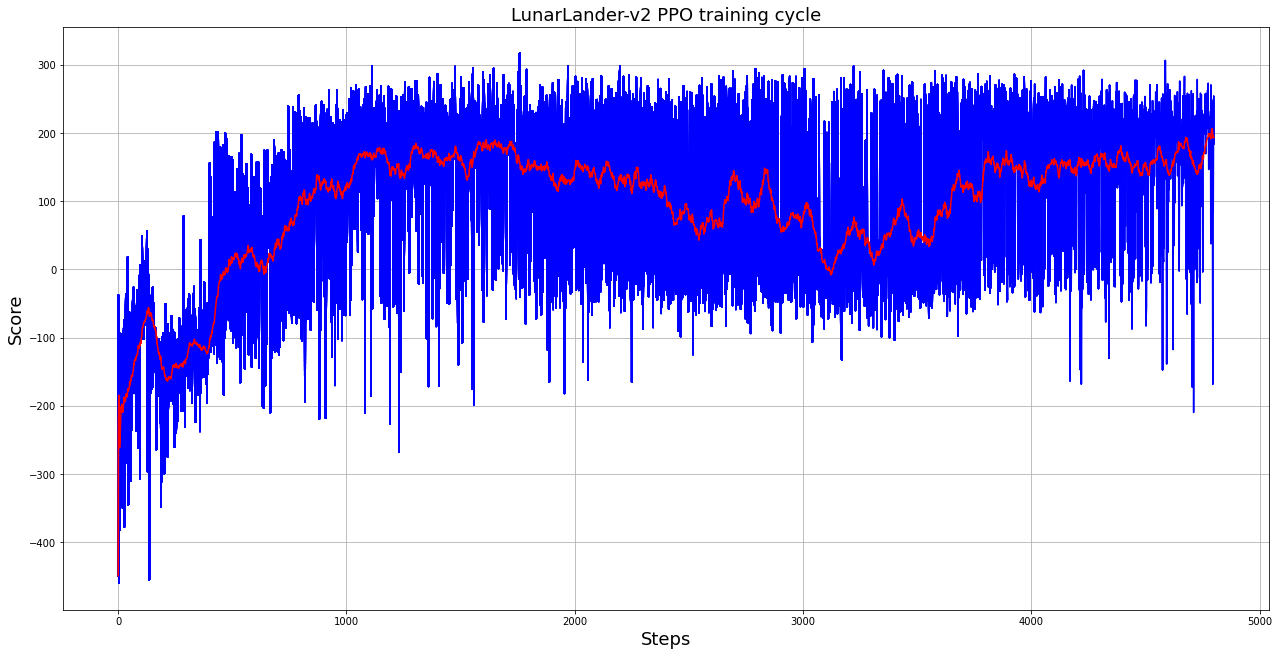

In [6]:

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # -1:cpu, 0:first gpu
import random
import gym
import pylab
import numpy as np
import tensorflow as tf
from tensorboardX import SummaryWriter
#tf.config.experimental_run_functions_eagerly(True) # used for debuging and development
tf.compat.v1.disable_eager_execution() # usually using this for fastest performance
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import backend as K
import copy

from threading import Thread, Lock
from multiprocessing import Process, Pipe
import time

gpus = tf.config.experimental.list_physical_devices('GPU')
if len(gpus) > 0:
    print(f'GPUs {gpus}')
    try: tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError: pass

class Environment(Process):
    def __init__(self, env_idx, child_conn, env_name, state_size, action_size, visualize=False):
        super(Environment, self).__init__()
        self.env = gym.make(env_name)
        self.is_render = visualize
        self.env_idx = env_idx
        self.child_conn = child_conn
        self.state_size = state_size
        self.action_size = action_size

    def run(self):
        super(Environment, self).run()
        state = self.env.reset()
        state = np.reshape(state, [1, self.state_size])
        self.child_conn.send(state)
        while True:
            action = self.child_conn.recv()
            if self.is_render and self.env_idx == 0:
                self.env.render()

            state, reward, done, info = self.env.step(action)
            state = np.reshape(state, [1, self.state_size])

            if done:
                state = self.env.reset()
                state = np.reshape(state, [1, self.state_size])

            self.child_conn.send([state, reward, done, info])


class Actor_Model:
    def __init__(self, input_shape, action_space, lr, optimizer):
        X_input = Input(input_shape)
        self.action_space = action_space

        X = Dense(512, activation="relu", kernel_initializer=tf.random_normal_initializer(stddev=0.01))(X_input)
        X = Dense(256, activation="relu", kernel_initializer=tf.random_normal_initializer(stddev=0.01))(X)
        X = Dense(64, activation="relu", kernel_initializer=tf.random_normal_initializer(stddev=0.01))(X)
        output = Dense(self.action_space, activation="softmax")(X)

        self.Actor = Model(inputs = X_input, outputs = output)
        self.Actor.compile(loss=self.ppo_loss, optimizer=optimizer(lr=lr))

    def ppo_loss(self, y_true, y_pred):
        # Defined in https://arxiv.org/abs/1707.06347
        advantages, prediction_picks, actions = y_true[:, :1], y_true[:, 1:1+self.action_space], y_true[:, 1+self.action_space:]
        LOSS_CLIPPING = 0.2
        ENTROPY_LOSS = 0.001
        
        prob = actions * y_pred
        old_prob = actions * prediction_picks

        prob = K.clip(prob, 1e-10, 1.0)
        old_prob = K.clip(old_prob, 1e-10, 1.0)

        ratio = K.exp(K.log(prob) - K.log(old_prob))
        
        p1 = ratio * advantages
        p2 = K.clip(ratio, min_value=1 - LOSS_CLIPPING, max_value=1 + LOSS_CLIPPING) * advantages

        actor_loss = -K.mean(K.minimum(p1, p2))

        entropy = -(y_pred * K.log(y_pred + 1e-10))
        entropy = ENTROPY_LOSS * K.mean(entropy)
        
        total_loss = actor_loss - entropy

        return total_loss

    def predict(self, state):
        return self.Actor.predict(state)


class Critic_Model:
    def __init__(self, input_shape, action_space, lr, optimizer):
        X_input = Input(input_shape)
        old_values = Input(shape=(1,))

        V = Dense(512, activation="relu", kernel_initializer='he_uniform')(X_input)
        V = Dense(256, activation="relu", kernel_initializer='he_uniform')(V)
        V = Dense(64, activation="relu", kernel_initializer='he_uniform')(V)
        value = Dense(1, activation=None)(V)

        self.Critic = Model(inputs=[X_input, old_values], outputs = value)
        self.Critic.compile(loss=[self.critic_PPO2_loss(old_values)], optimizer=optimizer(lr=lr))

    def critic_PPO2_loss(self, values):
        def loss(y_true, y_pred):
            LOSS_CLIPPING = 0.2
            clipped_value_loss = values + K.clip(y_pred - values, -LOSS_CLIPPING, LOSS_CLIPPING)
            v_loss1 = (y_true - clipped_value_loss) ** 2
            v_loss2 = (y_true - y_pred) ** 2
            
            value_loss = 0.5 * K.mean(K.maximum(v_loss1, v_loss2))
            #value_loss = K.mean((y_true - y_pred) ** 2) # standard PPO loss
            return value_loss
        return loss

    def predict(self, state):
        return self.Critic.predict([state, np.zeros((state.shape[0], 1))])

class PPOAgent:
    # PPO Main Optimization Algorithm
    def __init__(self, env_name):
        # Initialization
        # Environment and PPO parameters
        self.env_name = env_name       
        self.env = gym.make(env_name)
        self.action_size = self.env.action_space.n
        self.state_size = self.env.observation_space.shape
        self.EPISODES = 10000 # total episodes to train through all environments
        self.episode = 0 # used to track the episodes total count of episodes played through all thread environments
        self.max_average = 0 # when average score is above 0 model will be saved
        self.lr = 0.00025
        self.epochs = 10 # training epochs
        self.shuffle=False
        self.Training_batch = 1000
        #self.optimizer = RMSprop
        self.optimizer = Adam

        self.replay_count = 0
        self.writer = SummaryWriter(comment="_"+self.env_name+"_"+self.optimizer.__name__+"_"+str(self.lr))
        
        # Instantiate plot memory
        self.scores_, self.episodes_, self.average_ = [], [], [] # used in matplotlib plots

        # Create Actor-Critic network models
        self.Actor = Actor_Model(input_shape=self.state_size, action_space = self.action_size, lr=self.lr, optimizer = self.optimizer)
        self.Critic = Critic_Model(input_shape=self.state_size, action_space = self.action_size, lr=self.lr, optimizer = self.optimizer)
        
        self.Actor_name = f"{self.env_name}_PPO_Actor.h5"
        self.Critic_name = f"{self.env_name}_PPO_Critic.h5"

        
    def act(self, state):
        """ example:
        pred = np.array([0.05, 0.85, 0.1])
        action_size = 3
        np.random.choice(a, p=pred)
        result>>> 1, because it have the highest probability to be taken
        """
        # Use the network to predict the next action to take, using the model
        prediction = self.Actor.predict(state)[0]
        action = np.random.choice(self.action_size, p=prediction)
        action_onehot = np.zeros([self.action_size])
        action_onehot[action] = 1
        return action, action_onehot, prediction

    def discount_rewards(self, reward):#gaes is better
        # Compute the gamma-discounted rewards over an episode
        # We apply the discount and normalize it to avoid big variability of rewards
        gamma = 0.99    # discount rate
        running_add = 0
        discounted_r = np.zeros_like(reward)
        for i in reversed(range(0,len(reward))):
            running_add = running_add * gamma + reward[i]
            discounted_r[i] = running_add

        discounted_r -= np.mean(discounted_r) # normalizing the result
        discounted_r /= (np.std(discounted_r) + 1e-8) # divide by standard deviation
        return discounted_r

    def get_gaes(self, rewards, dones, values, next_values, gamma = 0.99, lamda = 0.9, normalize=True):
        deltas = [r + gamma * (1 - d) * nv - v for r, d, nv, v in zip(rewards, dones, next_values, values)]
        deltas = np.stack(deltas)
        gaes = copy.deepcopy(deltas)
        for t in reversed(range(len(deltas) - 1)):
            gaes[t] = gaes[t] + (1 - dones[t]) * gamma * lamda * gaes[t + 1]

        target = gaes + values
        if normalize:
            gaes = (gaes - gaes.mean()) / (gaes.std() + 1e-8)
        return np.vstack(gaes), np.vstack(target)

    def replay(self, states, actions, rewards, predictions, dones, next_states):
        # reshape memory to appropriate shape for training
        states = np.vstack(states)
        next_states = np.vstack(next_states)
        actions = np.vstack(actions)
        predictions = np.vstack(predictions)

        # Get Critic network predictions 
        values = self.Critic.predict(states)
        next_values = self.Critic.predict(next_states)

        # Compute discounted rewards and advantages
        #discounted_r = self.discount_rewards(rewards)
        #advantages = np.vstack(discounted_r - values)
        advantages, target = self.get_gaes(rewards, dones, np.squeeze(values), np.squeeze(next_values))
        '''
        pylab.plot(advantages,'.')
        pylab.plot(target,'-')
        ax=pylab.gca()
        ax.grid(True)
        pylab.subplots_adjust(left=0.05, right=0.98, top=0.96, bottom=0.06)
        pylab.show()
        '''
        # stack everything to numpy array
        # pack all advantages, predictions and actions to y_true and when they are received
        # in custom PPO loss function we unpack it
        y_true = np.hstack([advantages, predictions, actions])
        
        # training Actor and Critic networks
        a_loss = self.Actor.Actor.fit(states, y_true, epochs=self.epochs, verbose=0, shuffle=self.shuffle)
        c_loss = self.Critic.Critic.fit([states, values], target, epochs=self.epochs, verbose=0, shuffle=self.shuffle)

        self.writer.add_scalar('Data/actor_loss_per_replay', np.sum(a_loss.history['loss']), self.replay_count)
        self.writer.add_scalar('Data/critic_loss_per_replay', np.sum(c_loss.history['loss']), self.replay_count)
        self.replay_count += 1
 
    def load(self):
        self.Actor.Actor.load_weights(self.Actor_name)
        self.Critic.Critic.load_weights(self.Critic_name)

    def save(self):
        self.Actor.Actor.save_weights(self.Actor_name)
        self.Critic.Critic.save_weights(self.Critic_name)
        
    pylab.figure(figsize=(18, 9))
    pylab.subplots_adjust(left=0.05, right=0.98, top=0.96, bottom=0.06)
    def PlotModel(self, score, episode):
        self.scores_.append(score)
        self.episodes_.append(episode)
        self.average_.append(sum(self.scores_[-50:]) / len(self.scores_[-50:]))
        if str(episode)[-2:] == "00":# much faster than episode % 100
            pylab.plot(self.episodes_, self.scores_, 'b')
            pylab.plot(self.episodes_, self.average_, 'r')
            pylab.title(self.env_name+" PPO training cycle", fontsize=18)
            pylab.ylabel('Score', fontsize=18)
            pylab.xlabel('Steps', fontsize=18)
            try:
                pylab.grid(True)
                pylab.savefig(self.env_name+".png")
            except OSError:
                pass
        # saving best models
        if self.average_[-1] >= self.max_average:
            self.max_average = self.average_[-1]
            self.save()
            SAVING = "SAVING"
            # decreaate learning rate every saved model
            self.lr *= 0.95
            K.set_value(self.Actor.Actor.optimizer.learning_rate, self.lr)
            K.set_value(self.Critic.Critic.optimizer.learning_rate, self.lr)
        else:
            SAVING = ""

        return self.average_[-1], SAVING
    
    def run(self): # train only when episode is finished
        state = self.env.reset()
        state = np.reshape(state, [1, self.state_size[0]])
        done, score, SAVING = False, 0, ''
        while True:
            # Instantiate or reset games memory
            states, next_states, actions, rewards, predictions, dones = [], [], [], [], [], []
            while not done:
                self.env.render()
                # Actor picks an action
                action, action_onehot, prediction = self.act(state)
                # Retrieve new state, reward, and whether the state is terminal
                next_state, reward, done, _ = self.env.step(action)
                # Memorize (state, action, reward) for training
                states.append(state)
                next_states.append(np.reshape(next_state, [1, self.state_size[0]]))
                actions.append(action_onehot)
                rewards.append(reward)
                dones.append(done)
                predictions.append(prediction)
                # Update current state
                state = np.reshape(next_state, [1, self.state_size[0]])
                score += reward
                if done:
                    self.episode += 1
                    average, SAVING = self.PlotModel(score, self.episode)
                    print("episode: {}/{}, score: {}, average: {:.2f} {}".format(self.episode, self.EPISODES, score, average, SAVING))
                    self.writer.add_scalar(f'Workers:{1}/score_per_episode', score, self.episode)
                    self.writer.add_scalar(f'Workers:{1}/learning_rate', self.lr, self.episode)
                    
                    self.replay(states, actions, rewards, predictions, dones, next_states)

                    state, done, score, SAVING = self.env.reset(), False, 0, ''
                    state = np.reshape(state, [1, self.state_size[0]])

            if self.episode >= self.EPISODES:
                break
        self.env.close()

    def run_batch(self): # train every self.Training_batch episodes
        state = self.env.reset()
        state = np.reshape(state, [1, self.state_size[0]])
        done, score, SAVING = False, 0, ''
        while True:
            # Instantiate or reset games memory
            states, next_states, actions, rewards, predictions, dones = [], [], [], [], [], []
            for t in range(self.Training_batch):
                #self.env.render()
                # Actor picks an action
                action, action_onehot, prediction = self.act(state)
                # Retrieve new state, reward, and whether the state is terminal
                next_state, reward, done, _ = self.env.step(action)
                # Memorize (state, action, reward) for training
                states.append(state)
                next_states.append(np.reshape(next_state, [1, self.state_size[0]]))
                actions.append(action_onehot)
                rewards.append(reward)
                dones.append(done)
                predictions.append(prediction)
                # Update current state
                state = np.reshape(next_state, [1, self.state_size[0]])
                score += reward
                if done:
                    self.episode += 1
                    average, SAVING = self.PlotModel(score, self.episode)
                    print("episode: {}/{}, score: {}, average: {:.2f} {}".format(self.episode, self.EPISODES, score, average, SAVING))
                    self.writer.add_scalar(f'Workers:{1}/score_per_episode', score, self.episode)
                    self.writer.add_scalar(f'Workers:{1}/learning_rate', self.lr, self.episode)

                    state, done, score, SAVING = self.env.reset(), False, 0, ''
                    state = np.reshape(state, [1, self.state_size[0]])
                    
            self.replay(states, actions, rewards, predictions, dones, next_states)
            if self.episode >= self.EPISODES:
                break
        self.env.close()  

        
    def run_multiprocesses(self, num_worker = 4):
        works, parent_conns, child_conns = [], [], []
        for idx in range(num_worker):
            parent_conn, child_conn = Pipe()
            work = Environment(idx, child_conn, self.env_name, self.state_size[0], self.action_size, True)
            work.start()
            works.append(work)
            parent_conns.append(parent_conn)
            child_conns.append(child_conn)

        states =        [[] for _ in range(num_worker)]
        next_states =   [[] for _ in range(num_worker)]
        actions =       [[] for _ in range(num_worker)]
        rewards =       [[] for _ in range(num_worker)]
        dones =         [[] for _ in range(num_worker)]
        predictions =   [[] for _ in range(num_worker)]
        score =         [0 for _ in range(num_worker)]

        state = [0 for _ in range(num_worker)]
        for worker_id, parent_conn in enumerate(parent_conns):
            state[worker_id] = parent_conn.recv()

        while self.episode < self.EPISODES:
            predictions_list = self.Actor.predict(np.reshape(state, [num_worker, self.state_size[0]]))
            actions_list = [np.random.choice(self.action_size, p=i) for i in predictions_list]

            for worker_id, parent_conn in enumerate(parent_conns):
                parent_conn.send(actions_list[worker_id])
                action_onehot = np.zeros([self.action_size])
                action_onehot[actions_list[worker_id]] = 1
                actions[worker_id].append(action_onehot)
                predictions[worker_id].append(predictions_list[worker_id])

            for worker_id, parent_conn in enumerate(parent_conns):
                next_state, reward, done, _ = parent_conn.recv()

                states[worker_id].append(state[worker_id])
                next_states[worker_id].append(next_state)
                rewards[worker_id].append(reward)
                dones[worker_id].append(done)
                state[worker_id] = next_state
                score[worker_id] += reward

                if done:
                    average, SAVING = self.PlotModel(score[worker_id], self.episode)
                    print("episode: {}/{}, worker: {}, score: {}, average: {:.2f} {}".format(self.episode, self.EPISODES, worker_id, score[worker_id], average, SAVING))
                    self.writer.add_scalar(f'Workers:{num_worker}/score_per_episode', score[worker_id], self.episode)
                    self.writer.add_scalar(f'Workers:{num_worker}/learning_rate', self.lr, self.episode)
                    score[worker_id] = 0
                    if(self.episode < self.EPISODES):
                        self.episode += 1
                        
            for worker_id in range(num_worker):
                if len(states[worker_id]) >= self.Training_batch:
                    self.replay(states[worker_id], actions[worker_id], rewards[worker_id], predictions[worker_id], dones[worker_id], next_states[worker_id])
                    
                    states[worker_id] = []
                    next_states[worker_id] = []
                    actions[worker_id] = []
                    rewards[worker_id] = []
                    dones[worker_id] = []
                    predictions[worker_id] = []

        # terminating processes after while loop
        works.append(work)
        for work in works:
            work.terminate()
            print('TERMINATED:', work)
            work.join()
            

    def test(self, test_episodes = 100):
        self.load()
        for e in range(100):
            state = self.env.reset()
            state = np.reshape(state, [1, self.state_size[0]])
            done = False
            score = 0
            while not done:
                self.env.render()
                action = np.argmax(self.Actor.predict(state)[0])
                state, reward, done, _ = self.env.step(action)
                state = np.reshape(state, [1, self.state_size[0]])
                score += reward
                if done:
                    print("episode: {}/{}, score: {}".format(e, test_episodes, score))
                    break
        self.env.close()

if __name__ == "__main__":
    env_name = 'LunarLander-v2'
    agent = PPOAgent(env_name)
    #agent.run() # train as PPO, train every epesode
    agent.run_batch() # train as PPO, train every batch, trains better
    #agent.run_multiprocesses(num_worker = 8)  # train PPO multiprocessed (fastest)
    #agent.test()

In [ ]:
#agent.env.close()

In [7]:
%load_ext tensorboard
%tensorboard --logdir runs/Jul28_09-12-17_DESKTOP-2EB97UC_LunarLander-v2_Adam_0.00025